In [1]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 26. 01. 2024      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/gxfs_home/geomar/smomw723/EddiesHC_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import string # for subplot annotation
import matplotlib.pyplot as plt # for matlab-like plotting                                              
from matplotlib.patches import Rectangle # for shaded rectangle
import cartopy.crs as ccrs # for maps     
from matplotlib import gridspec
import matplotlib as mpl
#from cdo import *
#cdo = Cdo()
import os
import sys
import scipy
import warnings
import cmocean as cm
#from wrf import to_np # conversion to arrays required for arrows on maps    
import tarfile as tf
import io

import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import time
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#from dask.distributed import Client
#client = Client(n_workers=16)         # careful: do not run with 48 workers here as it will crash
#client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

/gxfs_home/geomar/smomw723/miniforge3/envs/py3_std/lib/python3.10/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


CPU times: user 1.74 s, sys: 1.52 s, total: 3.25 s
Wall time: 10.9 s


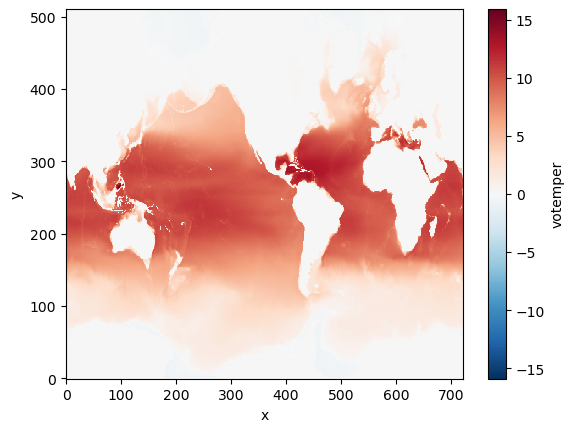

In [2]:
%%time
base = '/gxfs_work/geomar/smomw723/test_20251117_1159_OHC/'
fn   = 'test_20251117_1159_OHC_1m_20150101_20151231_grid_T.nc' 

rho_0 = 1035.0                       # global ocean average density of sea water   [kg m^{-3}]
C_p   = 3992.10322329649             # global ocean average specific heat capacity [J kg^{-1} K^{-1}]


ds = xr.open_mfdataset(base+fn).squeeze()
temp = ds.votemper
temp_adv = (ds.ttrd_xad + ds.ttrd_yad  + ds.ttrd_zad) # temperature advection
temp.mean(['time_counter', 'deptht']).plot()
# Wall time> 6.24 s

Text(0.5, 1.0, 'Vertically-integrated heat content')

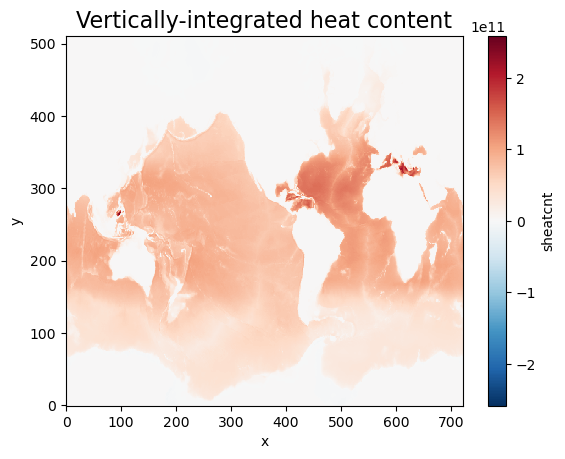

In [3]:
ds.sheatcnt.mean('time_counter').plot(); plt.title('Vertically-integrated heat content', fontsize=16)

In [4]:
%%time
# detect coordinate names
lat_name = [c for c in ds.coords if "lat" in c.lower()][0]
lon_name = [c for c in ds.coords if "lon" in c.lower()][0]

lat = ds[lat_name].values
lon = ds[lon_name].values

# 2D mesh or already lat2D/lon2D
if lat.ndim == 1 and lon.ndim == 1:
    lon2d, lat2d = np.meshgrid(lon, lat)
else:
    lon2d, lat2d = lon, lat

z = np.squeeze(ds.values)   # ensure 2-D

# convert lon to -180..180 for Cartopy
if np.nanmax(lon2d) > 180:
    lon2d = ((lon2d + 180) % 360) - 180
    
ticks = np.linspace(0,3,21) # ticks for colour bar

CPU times: user 7.48 ms, sys: 190 μs, total: 7.67 ms
Wall time: 6.82 ms


### Plotting routine

Text(0, 1, 'a')

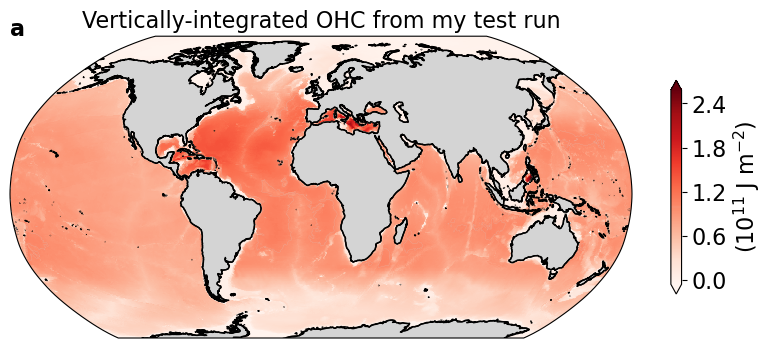

In [5]:
fs = 16
# Create figure and map
fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2, 2, width_ratios = [1,1]) 
ax1 = plt.subplot(gs[0,0], projection=ccrs.Robinson())

# Plot the data
p1 = ax1.pcolormesh(lon, lat, ds.sheatcnt.mean('time_counter')/1e11, transform=ccrs.PlateCarree(), cmap='Reds')
#p1  = sst.plot.contourf(cmap='RdBu_r',levels=ticks,add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
p11 = ax1.contour(lon, lat, ds.sheatcnt[0,:,:]/1e11, levels=[1], linewidths=.1, colors='lightgrey', transform=ccrs.PlateCarree())
#p11 = sst.plot.contour(levels = [0], linewidths=.1, colors='lightgrey', transform=ccrs.PlateCarree())


# Add land, coastlines, etc.
ax1.coastlines(resolution = '50m', linewidth=1) # add coast lines
ax1.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83, .83, .83], zorder = 1)
plt.title('Vertically-integrated OHC from my test run', fontsize=fs)

# add colour bar
cb = plt.colorbar(p1, shrink=.5, orientation='vertical', extend='both'); 
cb.set_label(label='(10$^{11}$ J m$^{-2}$)', size=fs)
cb.ax.tick_params(labelsize=fs); tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator;cb.update_ticks()  
cb.add_lines(p11) # add contours to colour bar

ax1.text(0, 1, string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold panel letter at the top left
# Wall time: 8.38 s

### Plotting routine for all budget term panels

CPU times: user 2min 51s, sys: 9.42 s, total: 3min
Wall time: 2min 57s


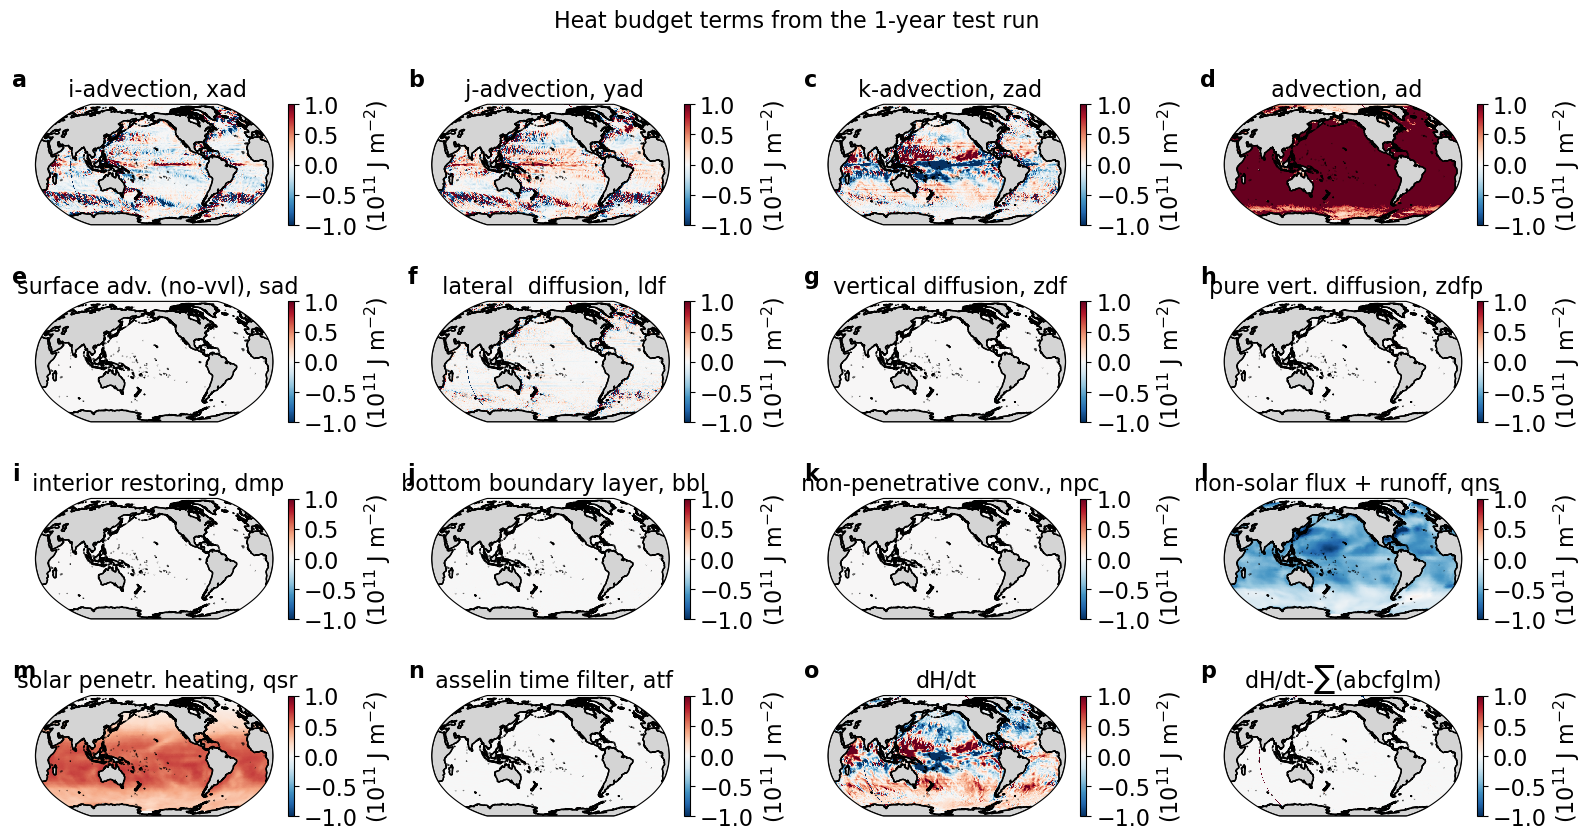

In [148]:
%%time
def fancy_plot(axes_nr):
    axes_nr.coastlines(resolution = '50m') # add coast lines
#    lon_formatter = cticker.LongitudeFormatter();
#    lat_formatter = cticker.LatitudeFormatter()
#    axes_nr.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
#    axes_nr.yaxis.set_major_formatter(lat_formatter) # "       "       "
#    axes_nr.xaxis.label.set_visible(False) # no axis labels
#    axes_nr.yaxis.label.set_visible(False)
#    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels

    # Add land, coastlines, etc.
    #ax1.coastlines(resolution = '50m', linewidth=1) # add coast lines
    axes_nr.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83, .83, .83], zorder = 1)
    #plt.title('Vertically-integrated OHC from my test run', fontsize=fs)

vars = [ds.ttrd_xad, ds.ttrd_yad, ds.ttrd_zad, ds.ttrd_ad,
        ds.ttrd_sad, ds.ttrd_ldf, ds.ttrd_zdf, ds.ttrd_zdfp, 
        ds.ttrd_dmp, ds.ttrd_bbl, ds.ttrd_npc, 
        ds.ttrd_qns, ds.ttrd_qsr, ds.ttrd_atf]

var_titles = ['Specific humidity', 'Sea level pressure', 'Surface air temperature', 'Zonal wind speed', 'Meridional wind speed',
             'Rainfall', 'Snowfall', 'Downward longwave', 'Downward shortwave', 'River runoff']
#var_units = ['10$^{-2}$ kg kg$^{-1}$', 'hPa', '°C', 'm s$^{-1}$', 'm s$^{-1}$',
#             '10$^{-5}$ kg m$^{-2}$ s$^{-1}$', '10$^{-6}$ kg m$^{-2}$ s$^{-1}$', 'W m$^{-2}$', 'W m$^{-2}$', 'kg m$^{-2}$ s$^{-1}$']
var_units = 'J m$^{-2}$'
exponent_scaling = 1e9
level_steps = [-1,1]
rho_0 = 1035.0                       # [kg m^{-3}]
C_p   = 3992.10322329649               # [J kg^{-1} K^{-1}]
deptht = ds.e3t

for f in range(1): # loop through El Nino and La Nina
    # initialise figure     ( l, h) -> length and height of plot 
    fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k') 

    for v in range(16): # loop through all variables
        # only plot the OHC budget terms for the first month and the surface layer, i.e., [0,0,:,:]
        if v in [0,1,2,3,5,6,7,8,9,10,11,12,13]: field = (vars[v] * rho_0 * C_p * deptht * (60*60*24*28))[1,:,:,:].sum(['deptht'])
        if v in [4]: field = vars[v][1:,:,:].sum(['time_counter']) # the ttrd_sad field is only 3D
        if v == 14: 
            vars_to_sum = ['ttrd_xad', 'ttrd_yad', 'ttrd_zad', 'ttrd_ldf', 'ttrd_zdf', 'ttrd_qns', 'ttrd_qsr']
            vars_to_sum = ['ttrd_xad', 'ttrd_yad', 'ttrd_zad', 'ttrd_ldf', 'ttrd_zdf', 'ttrd_qns', 'ttrd_qsr']
            sum_rhs = (ds[vars_to_sum].to_array().sum("variable")* rho_0 * C_p * deptht * (60*60*24*28))[1,:,:,:].sum('deptht')
            field       = sum_rhs
        if v == 15: 
            dHdt_lhs = ((ds.tempinst[1,:,:,:]-ds.tempinst[0,:,:,:]) * deptht[0,:,:,:] * rho_0 * C_p).sum(['deptht']) # 33 days between 1 Feb and 31 Dec 2015
            field = dHdt_lhs - sum_rhs

#        if v <= 13: field = (((vars[v]) * rho_0 * C_p * deptht * (60*60*24*365)).sum('deptht')[0,:,:]) / exponent_scaling       
#        if v == 14:                     field = (((vars[0]+vars[1]+vars[2]+vars[4]+vars[5]+vars[6]+vars[7]+vars[8]+vars[9]+vars[10]+vars[11]+vars[12]+vars[13]) * rho_0 * C_p * deptht * (60*60*24*365)).sum('deptht')[0,:,:]) / exponent_scaling     
#        if v == 15:                     field = (((vars[0]) * rho_0 * C_p * deptht * (60*60*24*365)).sum('deptht')[0,:,:]) / exponent_scaling
        
        if v <= 13: var_title = vars[v].long_name[18:] + ', ' + vars[v].name[5:]
        if v == 14: var_title = 'dH/dt'
        if v == 15: var_title = 'dH/dt-$\sum$(abcfglm)'
            
        ax1 = plt.subplot(4,4,v+1, projection=ccrs.Robinson(central_longitude=200)) # longitude starting at Cape Agulhas (20°E)
        # ------------------------------------ #
        p1  = ax1.pcolormesh(lon, lat, field/exponent_scaling, vmin=level_steps[0], vmax=level_steps[1], transform=ccrs.PlateCarree(), cmap='RdBu_r')
#        p11 = ax1.contour(lon, lat, field, levels=[1], linewidths=.1, colors='lightgrey', transform=ccrs.PlateCarree())
        # ------------------------------------ #

        # if v == 0: # add tick labels for °N and °S                                                    # transparent color
        #     grd = ax1.gridlines(draw_labels=True, xlocs=[22,180,0], ylocs=[-80,-40,0,40,80], color='#FF000000')
        #     grd.top_labels = False
        #     grd.xlabel_style = {'size': 16}; grd.ylabel_style = {'size': 16}

        # add colour bar   
        cb = plt.colorbar(p1, shrink=.5, orientation='vertical'); 
        cb.set_label(label='(10$^{11}$ '+var_units+')', size=16)
        cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
        cb.ax.yaxis.get_offset_text().set_fontsize(16) # set size of exponent if it appears
        cb.locator = tick_locator;cb.update_ticks() 
        cb.add_lines(p11) # add contours to colour bar
        
        plt.title(var_title, fontsize=16)
        fancy_plot(ax1)
        ax1.text(-.1, 1.15,string.ascii_lowercase[v], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        
        if v < 6: ax1.set_xticklabels([])  # remove unnecessary tick labels
        if v in [1,2,4,5,7,8]: ax1.set_yticklabels([])

        # add annotation text into middle of maps
#        ax1.text(0, 0, unit_vars, ha='center', va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        

    # fig.patch.set_linewidth(2); fig.patch.set_edgecolor('cornflowerblue') # border around the full plot to see the empty white space I have
    plt.suptitle('Feb. Heat budget terms from the 1-year test run', fontsize=16)
    
    # --- saving as 300 dpi .PNG image in specified folder --------------------- #
    plt.savefig(save + 'all_heat_budget_terms_Full_Robinson', 
                dpi=300, facecolor='w',                                          #
                edgecolor='w', orientation='landscape',                          #
                format=None, transparent=False, bbox_inches='tight',             #
                pad_inches=0.1, metadata=None)                                   #
    # --- end of script -------------------------------------------------------- # 
# Wall time: 1min 18s

CPU times: user 2.25 s, sys: 1.68 s, total: 3.93 s
Wall time: 1.9 s


Text(0.5, 1.0, '(c) Diff. LHS-RHS (J/m2)')

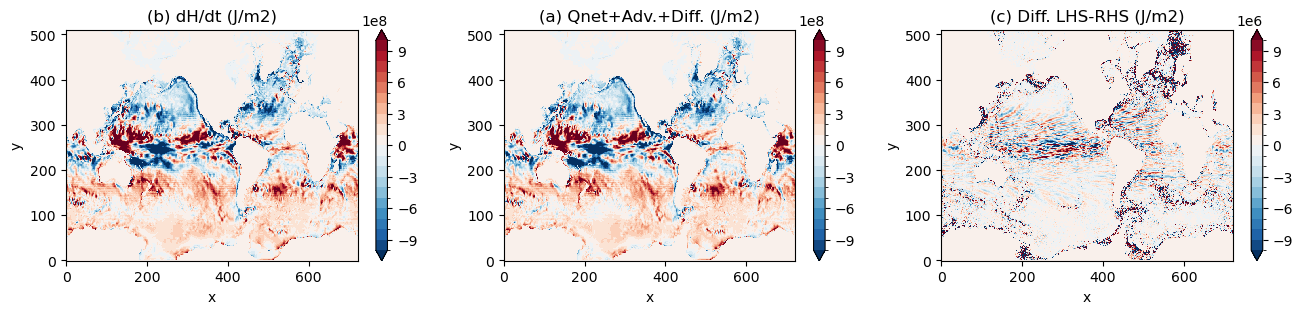

In [144]:
%%time
ticks = np.linspace(-1,1,21)


dHdt_lhs = ((ds.tempinst[1,:,:,:]-ds.tempinst[0,:,:,:]) * deptht[0,:,:,:] * rho_0 * C_p).sum(['deptht'])

vars_to_sum = ['ttrd_xad', 'ttrd_yad', 'ttrd_zad', 'ttrd_ldf', 'ttrd_zdf', 'ttrd_qns', 'ttrd_qsr']
sum_rhs = (ds[vars_to_sum].to_array().sum("variable")* rho_0 * C_p * deptht * (60*60*24*28))[1,:,:,:].sum('deptht')

ticks = np.linspace(-1e9,1e9,21)
plt.figure(figsize=(16,3))
plt.subplot(1,3,1); dHdt_lhs.plot(levels=ticks); plt.title('(b) dH/dt (J/m2)')
plt.subplot(1,3,2); sum_rhs.plot(levels=ticks); plt.title('(a) Qnet+Adv.+Diff. (J/m2)')
plt.subplot(1,3,3); (dHdt_lhs-sum_rhs).plot(levels=np.linspace(-1e7,1e7,21)); plt.title('(c) Diff. LHS-RHS (J/m2)')

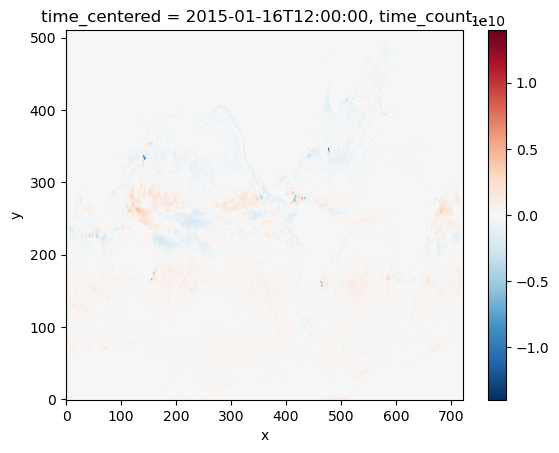

In [141]:
((ds.tempinst[1,:,:,:]-ds.tempinst[0,:,:,:]) * deptht[0,:,:,:] * rho_0 * C_p).sum(['deptht']).plot()

# BACKUP --- with temperature change in degC/s

CPU times: user 2min 20s, sys: 7.85 s, total: 2min 28s
Wall time: 2min 25s


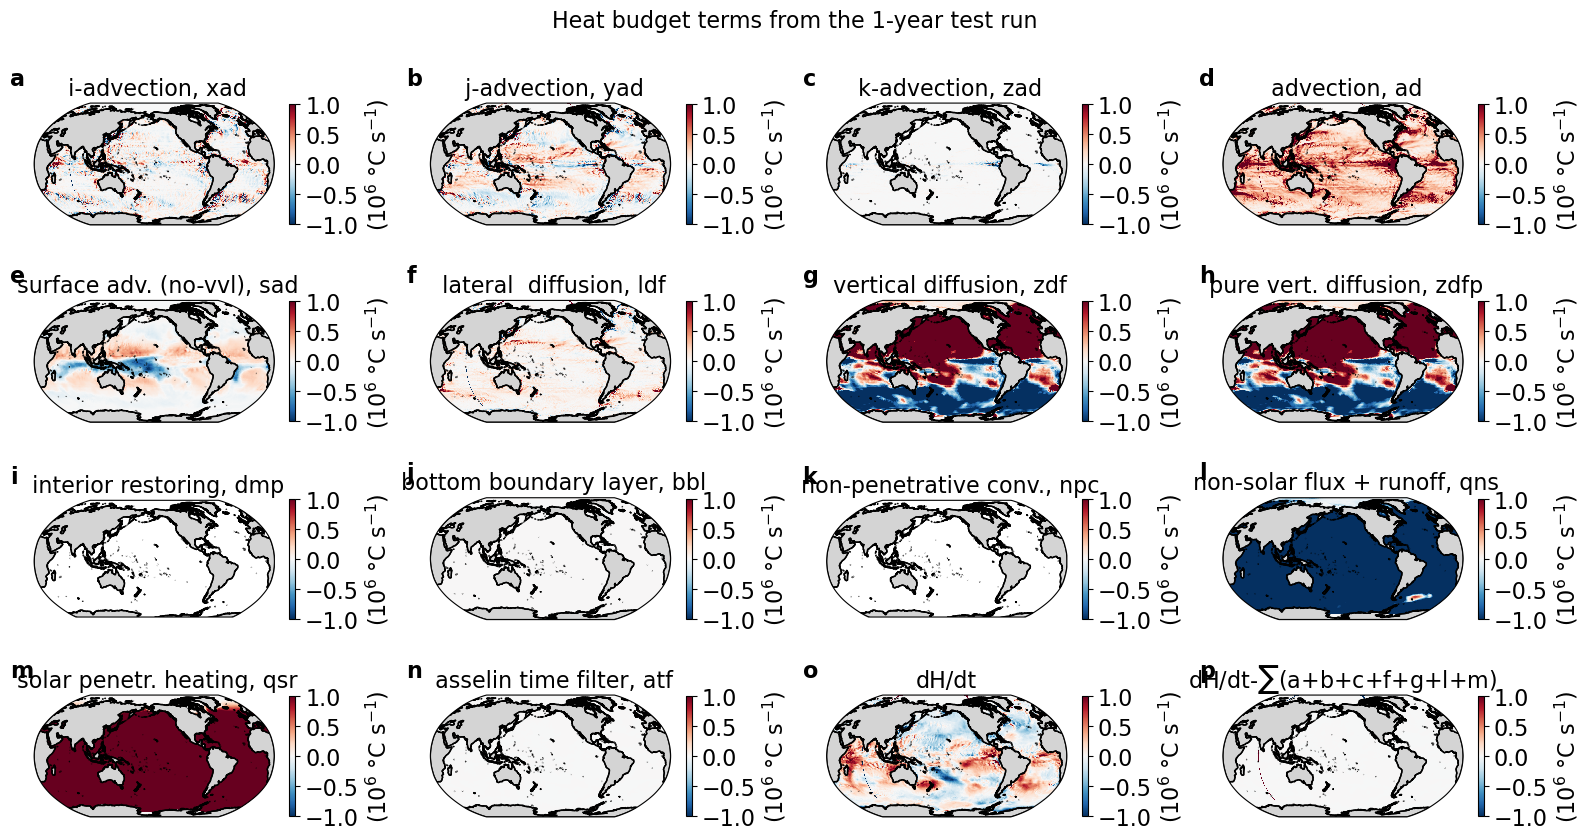

In [40]:
%%time
def fancy_plot(axes_nr):
    axes_nr.coastlines(resolution = '50m') # add coast lines
#    lon_formatter = cticker.LongitudeFormatter();
#    lat_formatter = cticker.LatitudeFormatter()
#    axes_nr.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
#    axes_nr.yaxis.set_major_formatter(lat_formatter) # "       "       "
#    axes_nr.xaxis.label.set_visible(False) # no axis labels
#    axes_nr.yaxis.label.set_visible(False)
#    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels

    # Add land, coastlines, etc.
    #ax1.coastlines(resolution = '50m', linewidth=1) # add coast lines
    axes_nr.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83, .83, .83], zorder = 1)
    #plt.title('Vertically-integrated OHC from my test run', fontsize=fs)

vars = [ds.ttrd_xad, ds.ttrd_yad, ds.ttrd_zad, ds.ttrd_ad,
        ds.ttrd_sad, ds.ttrd_ldf, ds.ttrd_zdf, ds.ttrd_zdfp, 
        ds.ttrd_dmp, ds.ttrd_bbl, ds.ttrd_npc, 
        ds.ttrd_qns, ds.ttrd_qsr, ds.ttrd_atf]

var_titles = ['Specific humidity', 'Sea level pressure', 'Surface air temperature', 'Zonal wind speed', 'Meridional wind speed',
             'Rainfall', 'Snowfall', 'Downward longwave', 'Downward shortwave', 'River runoff']
#var_units = ['10$^{-2}$ kg kg$^{-1}$', 'hPa', '°C', 'm s$^{-1}$', 'm s$^{-1}$',
#             '10$^{-5}$ kg m$^{-2}$ s$^{-1}$', '10$^{-6}$ kg m$^{-2}$ s$^{-1}$', 'W m$^{-2}$', 'W m$^{-2}$', 'kg m$^{-2}$ s$^{-1}$']
var_units = '°C s$^{-1}$'#'J m$^{-2}$'
exponent_scaling = 1e6
level_steps = [-1,1]
rho_0 = 1035.0                       # [kg m^{-3}]
C_p   = 3992.10322329649               # [J kg^{-1} K^{-1}]
deptht = ds.e3t

for f in range(1): # loop through El Nino and La Nina
    # initialise figure     ( l, h) -> length and height of plot 
    fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k') 

    for v in range(16): # loop through all variables
        # only plot the OHC budget terms for the first month and the surface layer, i.e., [0,0,:,:]
        if v in [0,1,2,3,5,6,7,8,9,10,11,12,13]: field = vars[v][1,0,:,:]
        if v in [4]: field = vars[v][1,:,:] # the ttrd_sad field is only 3D
        if v == 14: 
            vars_to_sum = ['ttrd_xad', 'ttrd_yad', 'ttrd_zad', 'ttrd_ldf', 'ttrd_zdf', 'ttrd_qns', 'ttrd_qsr']
            sum_rhs     = ds[vars_to_sum].to_array().sum("variable")[1,0,:,:]
            field       = sum_rhs
        if v == 15: 
            dHdt_lhs = ((ds.tempinst[1,0,:,:]-ds.tempinst[0,0,:,:])/(60*60*24*28))
            field = dHdt_lhs - sum_rhs

#        if v <= 13: field = (((vars[v]) * rho_0 * C_p * deptht * (60*60*24*365)).sum('deptht')[0,:,:]) / exponent_scaling       
#        if v == 14:                     field = (((vars[0]+vars[1]+vars[2]+vars[4]+vars[5]+vars[6]+vars[7]+vars[8]+vars[9]+vars[10]+vars[11]+vars[12]+vars[13]) * rho_0 * C_p * deptht * (60*60*24*365)).sum('deptht')[0,:,:]) / exponent_scaling     
#        if v == 15:                     field = (((vars[0]) * rho_0 * C_p * deptht * (60*60*24*365)).sum('deptht')[0,:,:]) / exponent_scaling
        
        if v <= 13: var_title = vars[v].long_name[18:] + ', ' + vars[v].name[5:]
        if v == 14: var_title = 'dH/dt'
        if v == 15: var_title = 'dH/dt-$\sum$(a+b+c+f+g+l+m)'
            
        ax1 = plt.subplot(4,4,v+1, projection=ccrs.Robinson(central_longitude=200)) # longitude starting at Cape Agulhas (20°E)
        # ------------------------------------ #
        p1  = ax1.pcolormesh(lon, lat, field*exponent_scaling, vmin=level_steps[0], vmax=level_steps[1], transform=ccrs.PlateCarree(), cmap='RdBu_r')
#        p11 = ax1.contour(lon, lat, field, levels=[1], linewidths=.1, colors='lightgrey', transform=ccrs.PlateCarree())
        # ------------------------------------ #

        # if v == 0: # add tick labels for °N and °S                                                    # transparent color
        #     grd = ax1.gridlines(draw_labels=True, xlocs=[22,180,0], ylocs=[-80,-40,0,40,80], color='#FF000000')
        #     grd.top_labels = False
        #     grd.xlabel_style = {'size': 16}; grd.ylabel_style = {'size': 16}

        # add colour bar   
        cb = plt.colorbar(p1, shrink=.5, orientation='vertical'); 
        cb.set_label(label='(10$^{6}$ '+var_units+')', size=16)
        cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
        cb.ax.yaxis.get_offset_text().set_fontsize(16) # set size of exponent if it appears
        cb.locator = tick_locator;cb.update_ticks() 
        cb.add_lines(p11) # add contours to colour bar
        
        plt.title(var_title, fontsize=16)
        fancy_plot(ax1)
        ax1.text(-.1, 1.15,string.ascii_lowercase[v], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        
        if v < 6: ax1.set_xticklabels([])  # remove unnecessary tick labels
        if v in [1,2,4,5,7,8]: ax1.set_yticklabels([])

        # add annotation text into middle of maps
#        ax1.text(0, 0, unit_vars, ha='center', va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        

    # fig.patch.set_linewidth(2); fig.patch.set_edgecolor('cornflowerblue') # border around the full plot to see the empty white space I have
    plt.suptitle('Heat budget terms from the 1-year test run', fontsize=16)
    
    # --- saving as 300 dpi .PNG image in specified folder --------------------- #
    plt.savefig(save + 'all_temperature_budget_terms_Full_Robinson', 
                dpi=300, facecolor='w',                                          #
                edgecolor='w', orientation='landscape',                          #
                format=None, transparent=False, bbox_inches='tight',             #
                pad_inches=0.1, metadata=None)                                   #
    # --- end of script -------------------------------------------------------- # 
# Wall time: 1min 18s

CPU times: user 1.74 s, sys: 4.24 s, total: 5.98 s
Wall time: 2.86 s


Text(0.5, 1.0, '(c) Diff. LHS-RHS (degC/s)')

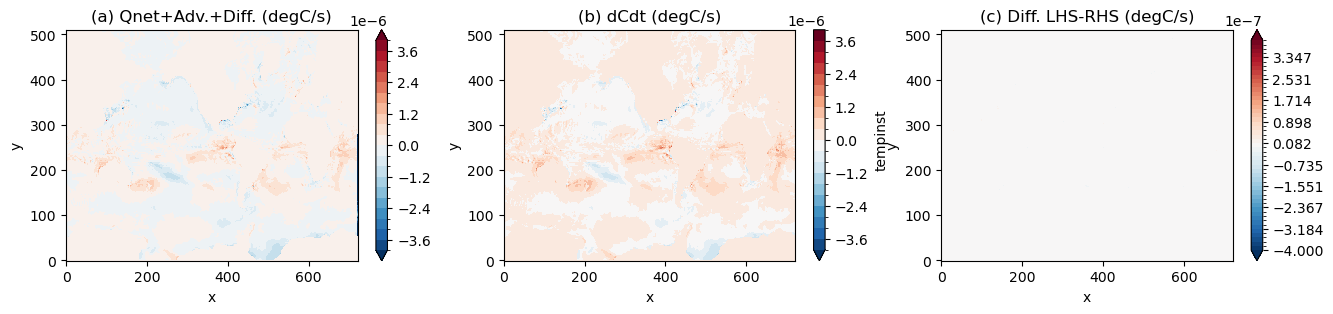

In [33]:
%%time
ticks = np.linspace(-1,1,21)

vars_to_sum = ['ttrd_xad', 'ttrd_yad', 'ttrd_zad', 'ttrd_ldf', 'ttrd_zdf', 'ttrd_qns', 'ttrd_qsr']
sum_rhs = ds[vars_to_sum].to_array().sum("variable")[1,0,:,:]
dHdt_lhs = ((ds.tempinst[1,0,:,:]-ds.tempinst[0,0,:,:])/(60*60*24*28))

ticks = np.linspace(-4e-6,4e-6,21)
plt.figure(figsize=(16,3))
plt.subplot(1,3,1); sum_rhs.plot(levels=ticks); plt.title('(a) Qnet+Adv.+Diff. (degC/s)')
plt.subplot(1,3,2); dHdt_lhs.plot(levels=ticks); plt.title('(b) dCdt (degC/s)')
plt.subplot(1,3,3); (dHdt_lhs-sum_rhs).plot(levels=np.linspace(-4e-7,4e-7)); plt.title('(c) Diff. LHS-RHS (degC/s)')

In [39]:
[(dHdt_lhs-sum_rhs).max().values, (dHdt_lhs-sum_rhs).min().values]

[array(0.00032225, dtype=float32), array(-1.3254034e-05, dtype=float32)]

In [9]:
sum_adv.sum(['x','y']).values

array(-7.820222e+13, dtype=float32)

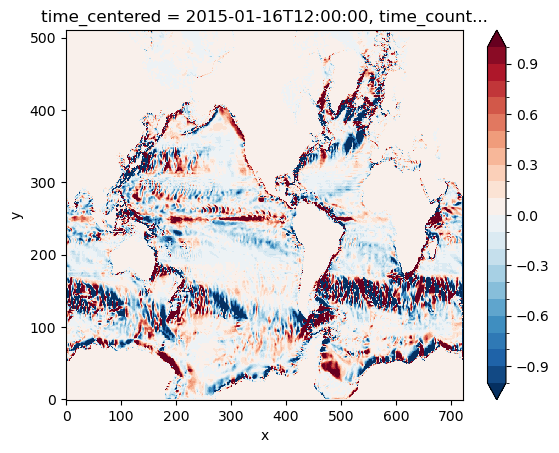

In [10]:
((vars[v] * rho_0 * C_p * deptht * (60*60*24*365)).sum('deptht')[0,:,:]/1e10).plot(levels=np.linspace(-1,1,21))

In [ ]:
fs = 16
# Create figure and map
fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(4, 4, width_ratios = [1,1]) 
for f in range(4):
    if f <= 4: s == 0
    if f >  4: s == 1
    ax1 = plt.subplot(gs[s,f], projection=ccrs.Robinson())
    

    # Plot the data
    #p1 = ax1.pcolormesh(lon, lat, ds.sheatcnt/1e11, transform=ccrs.PlateCarree(), cmap='Reds')
    #p1  = sst.plot.contourf(cmap='RdBu_r',levels=ticks,add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
    #p11 = ax1.contour(lon, lat, ds.sheatcnt/1e11, levels=[1], linewidths=.1, colors='lightgrey', transform=ccrs.PlateCarree())
    #p11 = sst.plot.contour(levels = [0], linewidths=.1, colors='lightgrey', transform=ccrs.PlateCarree())
    
    
    # Add land, coastlines, etc.
    ax1.coastlines(resolution = '50m', linewidth=1) # add coast lines
    ax1.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83, .83, .83], zorder = 1)
    plt.title('Vertically-integrated OHC from my test run', fontsize=fs)
    
    # add colour bar
    cb = plt.colorbar(p1, shrink=.5, orientation='vertical', extend='both'); 
    cb.set_label(label='(10$^{11}$ J m$^{-2}$)', size=fs)
    cb.ax.tick_params(labelsize=fs); tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator;cb.update_ticks()  
    cb.add_lines(p11) # add contours to colour bar
    
    ax1.text(0, 1, string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold panel letter at the top left
    # Wall time: 8.38 s